## Training Neural Networks

<img src="fig/nn.png" width=500 height=500 />

### Learning rate

Neural networks use gradient descent to update weights during backpropagation. Gradient descent is an optimization algorithm that adjusts weights based on the loss function's derivative. Weights are updated using the formula

<img src="fig/lr.png" width=150 height=150 />

### Gradient descent

Gradient descent is an optimization algorithm that optimizes a function by updating weights based on the function's derivative, also called the gradient. In machine learning, gradient descent is used to find the optimal weights for a model to minimize a loss function.

Neural networks use gradient descent to update weights during backpropagation

<img src="fig/lfun.png" width=300 height=300 />

### Loss functions and their derivative

<img src="fig/lossfun.png" width=500 height=500 />

### Stochastic and mini-batch gradient descent

Calculating gradients can be computationally intensive, especially for models with many input features and weights, such as neural networks. Stochastic gradient descent and mini-batch gradient descent are two options for reducing the computational load.

- __Stochastic gradient descent__ calculates the gradient and updates weights on one instance at a time.
- __Mini-batch gradient descent__ calculates the gradient and updates weights after each batch.

### Neural Netowrk in Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
Y = digits.target

In [3]:
print(X.shape)
print(Y.shape)

(1797, 64)
(1797,)


In [4]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [5]:
X = X / X.max()

In [6]:
X[0,:]

array([0.    , 0.    , 0.3125, 0.8125, 0.5625, 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.8125, 0.9375, 0.625 , 0.9375, 0.3125, 0.    ,
       0.    , 0.1875, 0.9375, 0.125 , 0.    , 0.6875, 0.5   , 0.    ,
       0.    , 0.25  , 0.75  , 0.    , 0.    , 0.5   , 0.5   , 0.    ,
       0.    , 0.3125, 0.5   , 0.    , 0.    , 0.5625, 0.5   , 0.    ,
       0.    , 0.25  , 0.6875, 0.    , 0.0625, 0.75  , 0.4375, 0.    ,
       0.    , 0.125 , 0.875 , 0.3125, 0.625 , 0.75  , 0.    , 0.    ,
       0.    , 0.    , 0.375 , 0.8125, 0.625 , 0.    , 0.    , 0.    ])

In [7]:
print(np.unique(Y))

[0 1 2 3 4 5 6 7 8 9]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

class MyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, n_classes):
        super(MyClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_layer_size[0])
        self.fc2 = nn.Linear(hidden_layer_size[0], hidden_layer_size[1])
        self.output = nn.Linear(hidden_layer_size[1], n_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [10]:
import torch.utils.data as Data

class MyData(Data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [11]:
Xtrain = MyData(X_train, y_train)
Xtest = MyData(X_test, y_test)
Xval = MyData(X_val, y_val)

In [12]:
batch_size = 16
train_loader = Data.DataLoader(Xtrain, batch_size=batch_size, shuffle=True, num_workers= 0)
test_loader = Data.DataLoader(Xtest, batch_size=batch_size, shuffle=True, num_workers= 0)
val_loader = Data.DataLoader(Xval, batch_size=batch_size, shuffle=True, num_workers= 0)

In [37]:
model = MyClassifier(X_train.shape[1], [100,50], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [38]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    #print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

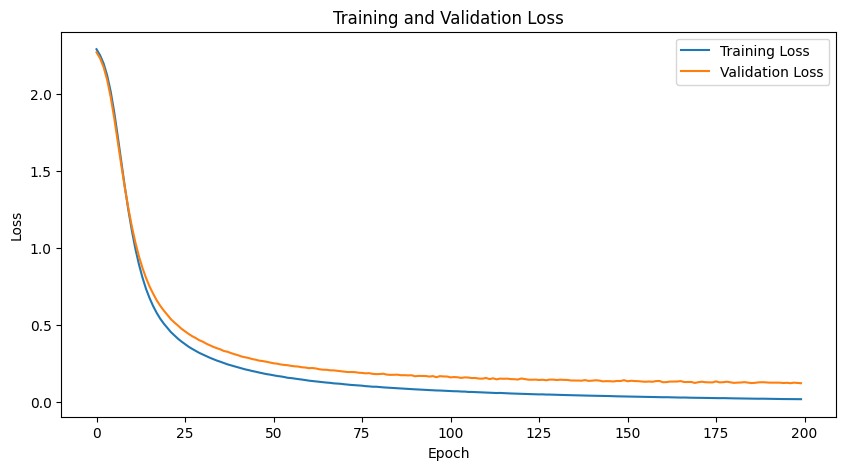

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [40]:
model.eval()
preds_ = []
labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        preds_.extend(preds.numpy())
        labels.extend(y_batch.numpy())

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cm = confusion_matrix(labels, preds_)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(labels, preds_))

Confusion Matrix:
 [[30  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  1]
 [ 0  0 37  0  0  0  0  0  0  0]
 [ 0  0  1 42  0  1  0  0  0  0]
 [ 0  1  0  0 34  0  0  0  0  1]
 [ 0  0  0  1  0 36  0  0  0  1]
 [ 0  0  0  0  0  0 26  0  0  0]
 [ 0  0  0  0  2  0  0 40  0  1]
 [ 0  3  0  0  0  0  0  0 31  0]
 [ 0  0  0  0  0  1  0  0  1 33]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.90      0.97      0.94        37
           2       0.97      1.00      0.99        37
           3       0.98      0.95      0.97        44
           4       0.94      0.94      0.94        36
           5       0.95      0.95      0.95        38
           6       1.00      1.00      1.00        26
           7       1.00      0.93      0.96        43
           8       0.97      0.91      0.94        34
           9       0.89      0.94      0.92        35

    accuracy                  

In [42]:
print(f'accuracy_score = {accuracy_score(labels, preds_)}')

accuracy_score = 0.9583333333333334
